In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [2]:
### 1. Preprocess your Titanic training data 

In [3]:
train_df=pd.read_csv("C:\\Users\\grsam\\OneDrive\\Desktop\\CourseWork\\Assignments\\ML_Assignments\\TitanicAssignment\\train.csv")
test_df=pd.read_csv("C:\\Users\\grsam\\OneDrive\\Desktop\\CourseWork\\Assignments\\ML_Assignments\\TitanicAssignment\\test.csv")
combine_df = [train_df, test_df]
test_ids=test_df["PassengerId"]

In [4]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine_df = [train_df, test_df]
PassengerId = test_df['PassengerId']

In [5]:
for dataset in combine_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
# fill missing values with median column values
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

# Fill embarked with mode
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
# Fillin Fare using mode
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)    
combine_df = [train_df, test_df]

# Convert Fare feature to ordinal values
for dataset in combine_df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
#Drop Name,PassengerId
train_df = train_df.drop(['Name','PassengerId'], axis=1)
test_df = test_df.drop(['Name','PassengerId'], axis=1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int32  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    int32  
 6   Embarked  418 non-null    int32  
dtypes: float64(1), int32(3), int64(3)
memory usage: 18.1 KB


C:\Users\grsam\AppData\Local\Temp\ipykernel_21844\3788815857.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_df.fillna(train_df.median(), inplace=True)
C:\Users\grsam\AppData\Local\Temp\ipykernel_21844\3788815857.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df.fillna(test_df.median(), inplace=True)


In [6]:
#Modeling 
X_train = train_df.drop(["Survived"], axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop(["SibSp"], axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 6))

In [7]:
# Plotting decision tree

[Text(0.4451499607252038, 0.9761904761904762, 'Sex <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = died'),
 Text(0.12811411981997284, 0.9285714285714286, 'Age <= 6.5\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = died'),
 Text(0.02309782608695652, 0.8809523809523809, 'SibSp <= 2.5\ngini = 0.444\nsamples = 24\nvalue = [8, 16]\nclass = survived'),
 Text(0.017663043478260868, 0.8333333333333334, 'gini = 0.0\nsamples = 15\nvalue = [0, 15]\nclass = survived'),
 Text(0.028532608695652172, 0.8333333333333334, 'Age <= 2.5\ngini = 0.198\nsamples = 9\nvalue = [8, 1]\nclass = died'),
 Text(0.02309782608695652, 0.7857142857142857, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]\nclass = died'),
 Text(0.033967391304347824, 0.7857142857142857, 'Age <= 3.5\ngini = 0.375\nsamples = 4\nvalue = [3, 1]\nclass = died'),
 Text(0.028532608695652172, 0.7380952380952381, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = survived'),
 Text(0.03940217391304348, 0.7380952380952381, 'gini = 0.

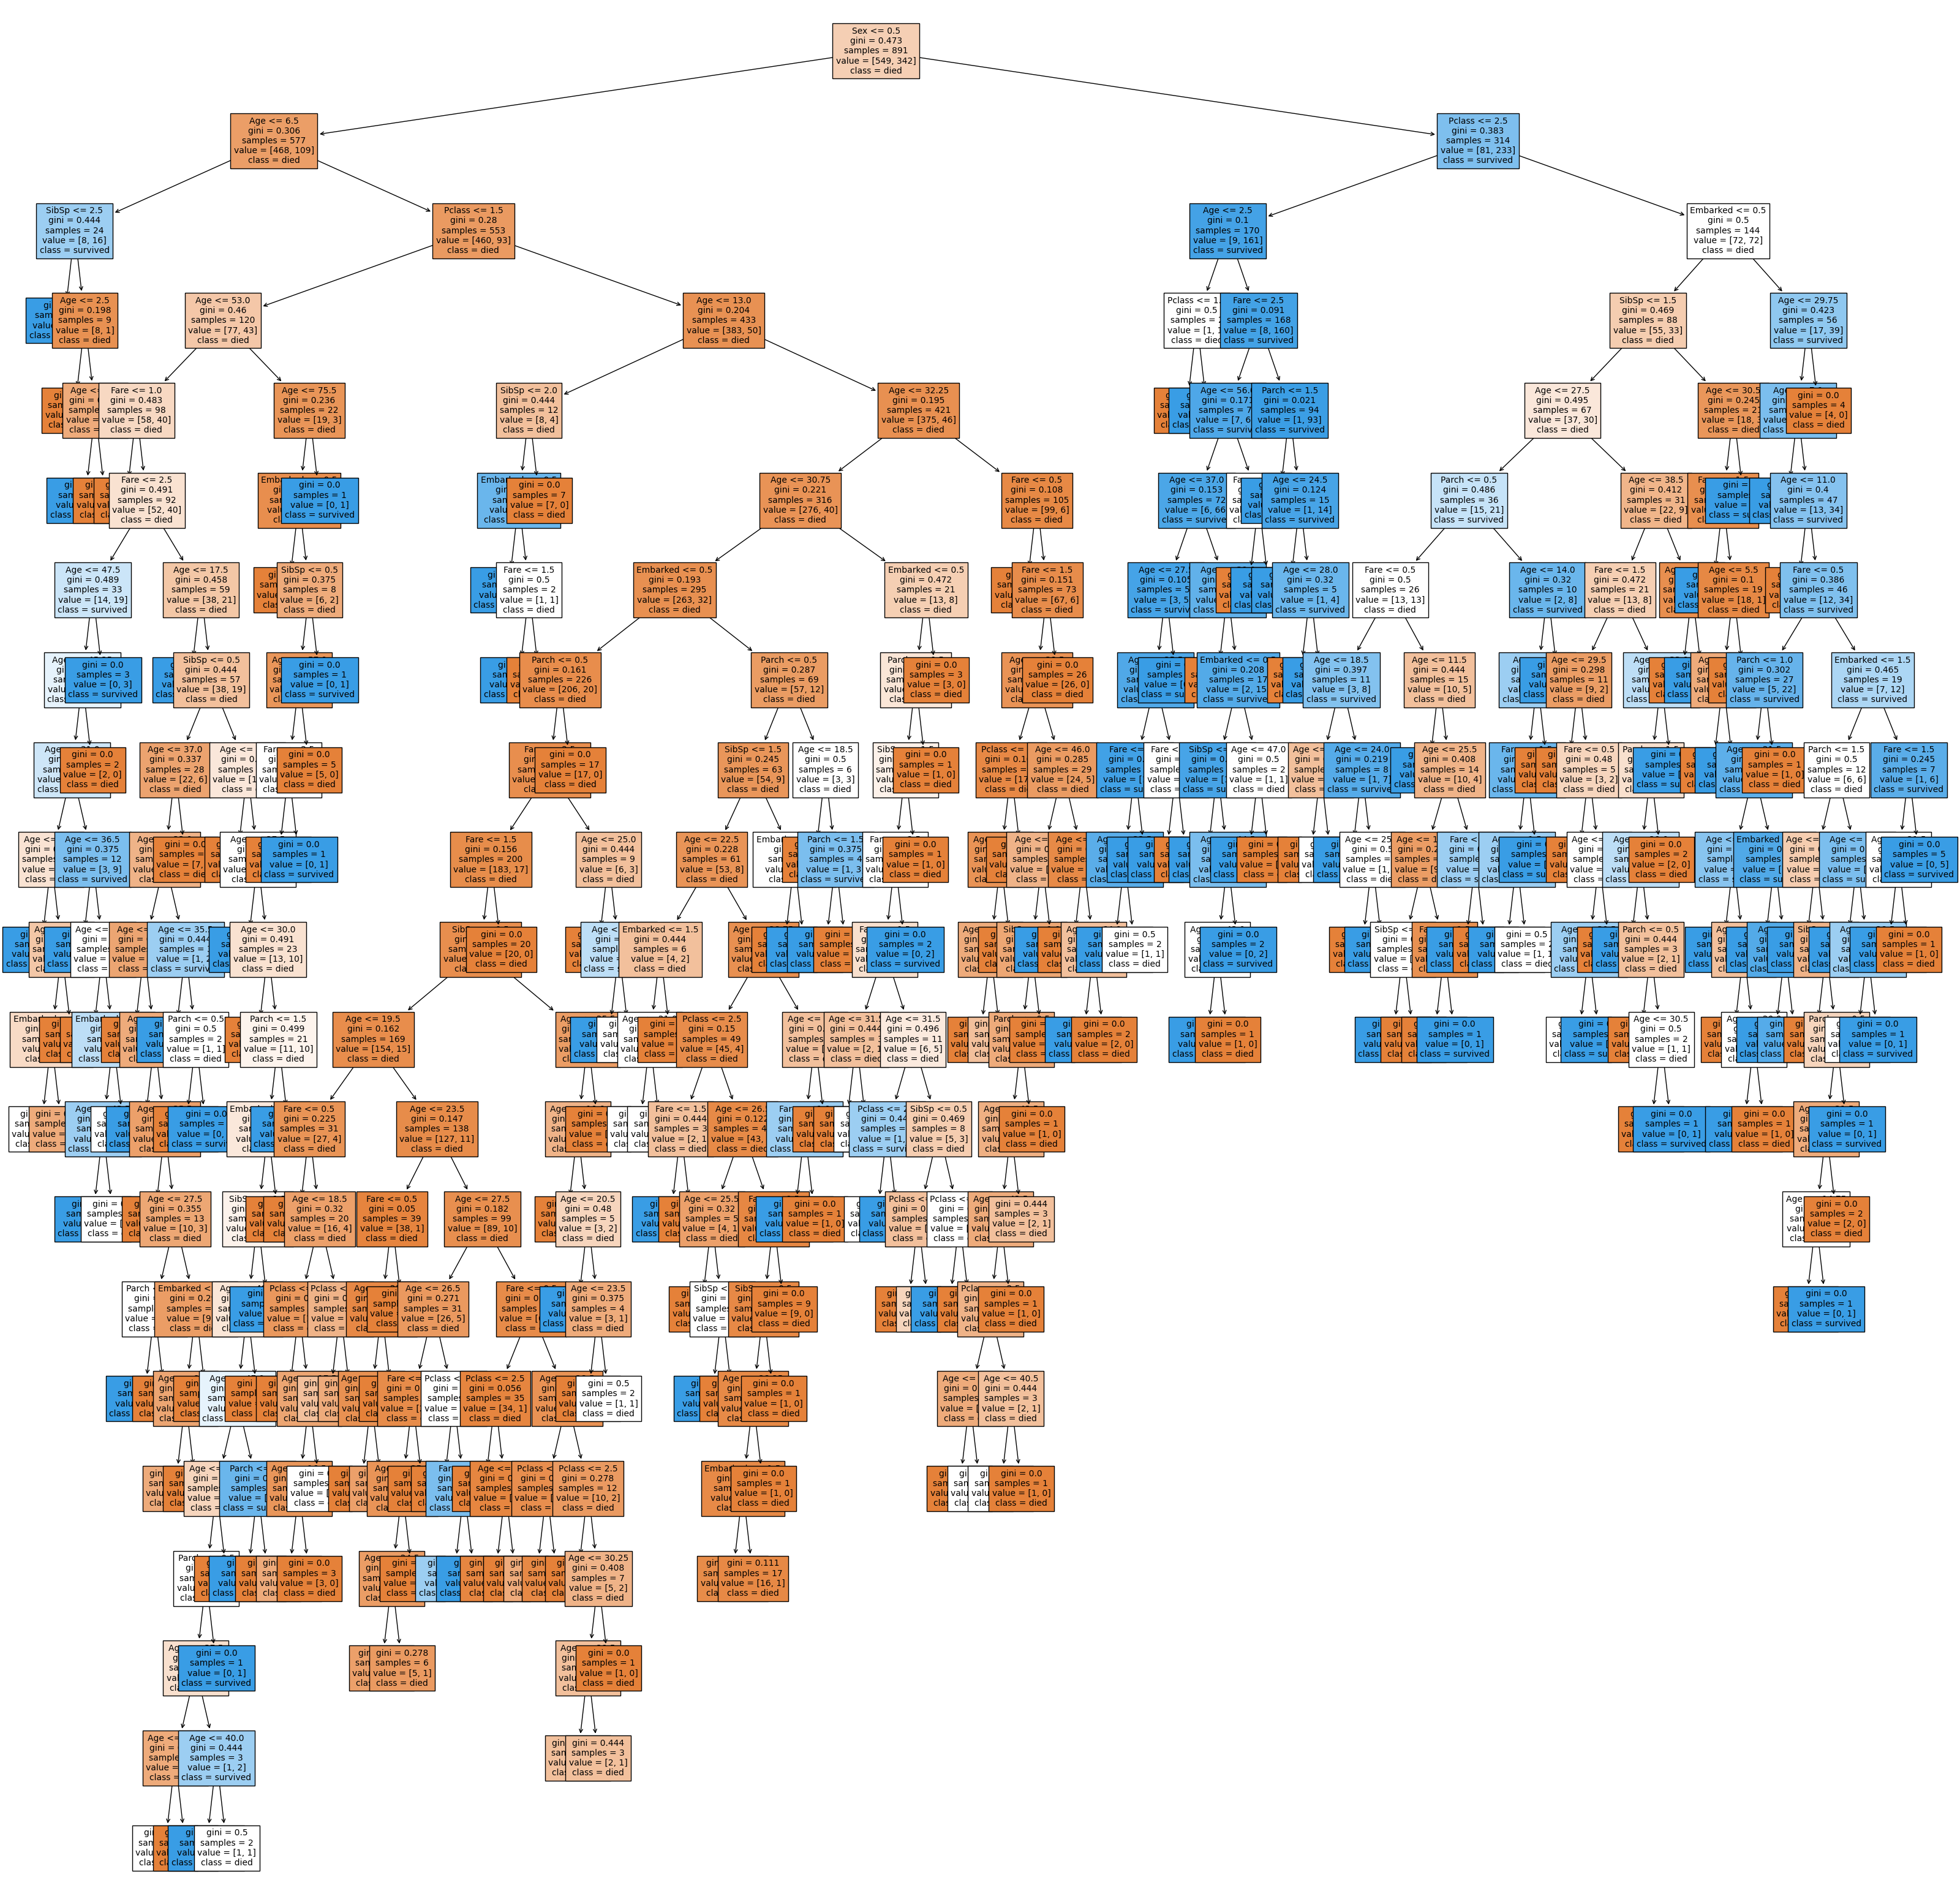

In [8]:
dt=DecisionTreeClassifier(criterion='gini',random_state=42)
dt_model=dt.fit(X_train, Y_train)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, 
                       random_state=42, splitter='best')
plt.figure(figsize=(40,40))  
feature_names = list(X_train.columns)
class_names = ['died','survived']
tree.plot_tree(dt, fontsize=10, filled=True,feature_names=feature_names, class_names=class_names)

In [9]:
decision_tree = DecisionTreeClassifier(criterion='gini',random_state = 42, max_depth=4)
clf = decision_tree.fit(X_train, Y_train)
feature_names = list(X_train.columns)


In [10]:
# 5-Fold Cross Validation of DT:

In [11]:
decision_tree = DecisionTreeClassifier(max_depth=4)
clf = decision_tree.fit(X_train, Y_train)
acc = cross_val_score(clf, X_train, Y_train, cv=5)
scores = cross_val_score(clf, X_train, Y_train, cv=5, scoring='roc_auc')

print("5K CV Decision tree classification accuracy:", acc)
print("5K CV Decision tree average classification accuracy: ", acc.mean())
print("=== Mean AUC Score ===")
print("Training Mean AUC Score - Decision tree: ", scores.mean())

5K CV Decision tree classification accuracy: [0.80446927 0.81460674 0.80898876 0.78651685 0.85955056]
5K CV Decision tree average classification accuracy:  0.8148264390182665
=== Mean AUC Score ===
Training Mean AUC Score - Decision tree:  0.8382363410969784


In [12]:
# 4. Apply the five-fold cross validation of your fine-tuned random forest learning model to the Titanic training data to extract average classification accuracy (5 points)

In [13]:
random_forest = RandomForestClassifier(n_estimators=400,random_state = 22)
rf = random_forest.fit(X_train, Y_train)
acc = cross_val_score(rf, X_train, Y_train, cv=5)
scores = cross_val_score(rf, X_train, Y_train, cv=5, scoring='roc_auc')

print("5K CV Random Forest classification accuracy:", acc)
print("5K CV Random Forest average classification accuracy: ", acc.mean())
print("=== Mean AUC Score ===")
print("Training Mean AUC Score - Random Forest: ", scores.mean())

5K CV Random Forest classification accuracy: [0.79329609 0.78651685 0.83146067 0.79213483 0.84269663]
5K CV Random Forest average classification accuracy:  0.8092210156299041
=== Mean AUC Score ===
Training Mean AUC Score - Random Forest:  0.845765939149348


In [14]:

X = train_df.drop(columns=['Survived','SibSp','Parch','Embarked']).values
Y = train_df['Survived'].values
XX_train_df, XX_test, YY_train_df, YY_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)

# Building Decision Tree
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 22)
dt.fit(XX_train_df, YY_train_df)
dt_pred_train_df = dt.predict(XX_train_df)

# Evaluation on train set
dt_pred_train_df = dt.predict(XX_train_df)
print('DT train Set Evaluation F1-Score=>',f1_score(YY_train_df,dt_pred_train_df))

# Evaluating on Test set
dt_pred_test = dt.predict(XX_test)
print('DT Validation Set Evaluation F1-Score=>',f1_score(YY_test,dt_pred_test))

# Building  Random Forest Classifier
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 22)
rfc.fit(XX_train_df, YY_train_df)

# Evaluating on train set
rfc_pred_train_df = rfc.predict(XX_train_df)
print('RF train Set Evaluation F1-Score=>',f1_score(YY_train_df,rfc_pred_train_df))

# Evaluating on Test set
rfc_pred_test = rfc.predict(XX_test)
print('RF Validation Set Evaluation F1-Score=>',f1_score(YY_test,rfc_pred_test))

DT train Set Evaluation F1-Score=> 0.8988326848249028
DT Validation Set Evaluation F1-Score=> 0.7299270072992701
RF train Set Evaluation F1-Score=> 0.9011406844106464
RF Validation Set Evaluation F1-Score=> 0.7375886524822696
